In [1]:
import pandas as pd
import matplotlib.pyplot as plt

naive_times = pd.DatetimeIndex(start='2017', end='2018', freq='1h')

# very approximate
# latitude, longitude, name, altitude, timezone
coordinates = [(52.5, 13.4, 'Berlin', 34, 'Etc/GMT-2'),
(43.6, -79.4, 'Toronto', 77, 'Etc/GMT+4'),
(42.3, -71.2, 'Boston', 43, 'Etc/GMT+4'),
(61.2, -149.9, 'Anchorage', 31, 'Etc/GMT+8'),  #Anchorage is Alaska's most pupulated and warmest city    
(30, -110, 'Tucson', 700, 'Etc/GMT+7')]

import pvlib

# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']

# specify constant ambient air temp and wind for simplicity
temp_air = 20

wind_speed = 0

In [2]:
system = {'module': module, 'inverter': inverter,
           'surface_azimuth': 180}

In [3]:
energies = {}
ac_locs = {}
NCF = {}  #Net Capacity Factor: Divide sum of generation by the number of periods times the system size
# NCF_monthly=pd.DataFrame(columns=[list(range(len(coordinates)))])
NCF_monthly={}


for latitude, longitude, name, altitude, timezone in coordinates:
        times = naive_times.tz_localize(timezone)
        system['surface_tilt'] = latitude
        solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
        dni_extra = pvlib.irradiance.get_extra_radiation(times)
        airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
        pressure = pvlib.atmosphere.alt2pres(altitude)
        am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
        tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
        cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl,
                                     dni_extra=dni_extra, altitude=altitude)
        aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'],
                                   solpos['apparent_zenith'], solpos['azimuth'])
        total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'],
                                                            system['surface_azimuth'],
                                                            solpos['apparent_zenith'],
                                                            solpos['azimuth'],
                                                            cs['dni'], cs['ghi'], cs['dhi'],
                                                            dni_extra=dni_extra,
                                                            model='haydavies')
        temps = pvlib.pvsystem.sapm_celltemp(total_irrad['poa_global'],
                                             wind_speed, temp_air)
        effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
            total_irrad['poa_direct'], total_irrad['poa_diffuse'],
            am_abs, aoi, module)
        dc = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)
        ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)
        annual_energy = ac.sum()
        energies[name] = annual_energy
        interval=60
        system_capacity=220
        NCF[name]=annual_energy/(525600/int(interval) * system_capacity)
        ac_locs[name]=ac
        ac_mth_agg=ac.resample('M',how='sum')
        ncf_mon=ac_mth_agg/((740*60)/int(interval) * system_capacity)
        NCF_monthly[name]=pd.DataFrame(ncf_mon)


C:\Users\Mhdella\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


In [4]:
df_ac_locs=pd.DataFrame(ac_locs)
df_ac_locs
len(df_ac_locs.columns)
df_ac_magg=pd.DataFrame(ac_mth_agg)
# df_ac_magg
# ac_mth_agg
# len(df_ac_magg.columns)
# NCF_monthly

In [5]:
energies = pd.Series(energies)
NCF = pd.Series(NCF)
# based on the parameters specified above, these are in W*hrs
# print(energies.round(0))
decf = {'Energy':energies,'NCF':NCF}
df_E_NCF = pd.DataFrame(decf)
df_E_NCF

,Energy,NCF
Berlin,397459.415494,0.206237
Toronto,439808.691181,0.228211
Boston,451894.591553,0.234482
Anchorage,351057.399724,0.182159
Tucson,467728.320261,0.242698


Text(0,0.5,'Yearly energy yield (W hr)')

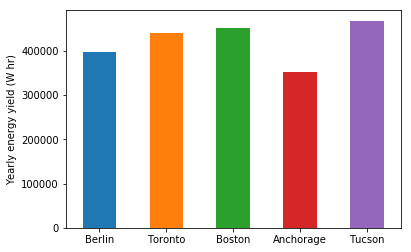

In [6]:
energies.plot(kind='bar', rot=0)

plt.ylabel('Yearly energy yield (W hr)')


In [7]:
energies.head()
ac.head()
# ac.describe()
annual_energy

467728.3202605598

In [8]:
system_capacity=220
max(ac)

187.71222206865693

In [9]:
# print(ac_mth_agg) 

In [10]:
ac_mth_agg/((740*60)/int(interval) * system_capacity)

2017-01-31 00:00:00-07:00    2.257373e-01
2017-02-28 00:00:00-07:00    2.230080e-01
2017-03-31 00:00:00-07:00    2.613212e-01
2017-04-30 00:00:00-07:00    2.528277e-01
2017-05-31 00:00:00-07:00    2.530311e-01
2017-06-30 00:00:00-07:00    2.366182e-01
2017-07-31 00:00:00-07:00    2.443788e-01
2017-08-31 00:00:00-07:00    2.500256e-01
2017-09-30 00:00:00-07:00    2.456848e-01
2017-10-31 00:00:00-07:00    2.458991e-01
2017-11-30 00:00:00-07:00    2.208980e-01
2017-12-31 00:00:00-07:00    2.135943e-01
2018-01-31 00:00:00-07:00   -1.228501e-07
Freq: M, dtype: float64

In [11]:
NCF_monthly

{'Berlin':                                       0
 2017-01-31 00:00:00+02:00  1.472299e-01
 2017-02-28 00:00:00+02:00  1.786189e-01
 2017-03-31 00:00:00+02:00  2.188905e-01
 2017-04-30 00:00:00+02:00  2.376251e-01
 2017-05-31 00:00:00+02:00  2.476931e-01
 2017-06-30 00:00:00+02:00  2.373505e-01
 2017-07-31 00:00:00+02:00  2.445675e-01
 2017-08-31 00:00:00+02:00  2.445872e-01
 2017-09-30 00:00:00+02:00  2.189556e-01
 2017-10-31 00:00:00+02:00  1.922862e-01
 2017-11-30 00:00:00+02:00  1.475138e-01
 2017-12-31 00:00:00+02:00  1.260786e-01
 2018-01-31 00:00:00+02:00 -1.228501e-07,
 'Toronto':                                       0
 2017-01-31 00:00:00-04:00  1.851558e-01
 2017-02-28 00:00:00-04:00  2.073311e-01
 2017-03-31 00:00:00-04:00  2.530543e-01
 2017-04-30 00:00:00-04:00  2.515467e-01
 2017-05-31 00:00:00-04:00  2.509458e-01
 2017-06-30 00:00:00-04:00  2.368521e-01
 2017-07-31 00:00:00-04:00  2.454647e-01
 2017-08-31 00:00:00-04:00  2.472993e-01
 2017-09-30 00:00:00-04:00  2.39748